In [1]:
pip install -U tensorflow_addons

In [2]:
!pip install -U tensorflow_hub
!pip install -U google.colab

In [3]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_addons as tfa

In [4]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize


drive.mount('/content/drive')

os.chdir ("/content/drive/MyDrive/FourthBrain/Capstone Samsung OCT/Data/OCT2017")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
train_dir = os.getcwd() + "/train/"
valid_dir = os.getcwd() + "/val/"
test_dir = os.getcwd() + "/test/"

In [6]:
classes = ['NORMAL', 'CNV', 'DME', 'DRUSEN']
cols = [x.lower() for x in classes]
dirs = [train_dir, valid_dir, test_dir]
label = {0: 'normal', 1: 'cnv', 2: 'dme', 3: 'drusen'}

REGEN = False # if we should read the directory structre, if False then use the CSV files already saved

In [7]:
def create_df (path, classes=classes):
  df = pd.DataFrame(columns=['filename', 'normal', 'cnv', 'dme', 'drusen'])
  for sub_dir in classes:
    condition = {'normal': 0, 'cnv': 0, 'dme':0, 'drusen': 0}
    files = os.listdir(path + sub_dir)
    if (sub_dir== 'NORMAL'):
      condition['normal'] = 1
    elif (sub_dir == 'CNV'):
      condition['cnv'] = 1
    elif (sub_dir == 'DME'):
      condition['dme'] = 1
    else:
      condition['drusen']= 1
    for f in files:
      df = df.append({'filename': path +  sub_dir  + "/" + f, 
                      'normal': condition['normal'], 
                      'cnv': condition['cnv'],
                      'dme': condition['dme'],
                      'drusen': condition['drusen']}, ignore_index=True)
  return df

In [8]:
# Generting the DataFrames of the filenames
# this is primarily used so we can sub-sample files easier for the different training strategies
if (REGEN):
  train_df = create_df(train_dir)
  valid_df = create_df(valid_dir)
  test_df = create_df(test_dir)
  train_df.to_csv("train_data.csv")
  valid_df.to_csv("valid_data.csv")
  test_df.to_csv("test_data.csv")
else:
  train_df = pd.read_csv("train_data.csv")
  valid_df = pd.read_csv("valid_data.csv")
  test_df = pd.read_csv("test_data.csv")

In [9]:
print ("Training Data: ", train_df.shape)
print ("Validation Data: ", valid_df.shape)
print ("Test Data: ", test_df.shape)

Training Data:  (83484, 6)
Validation Data:  (32, 6)
Test Data:  (968, 6)


In [10]:
# Printing out the # of samples for each subsample percentage 
print ("Trainig Data percentages:")
print (" 1% ==> ", int(.01 * train_df.shape[0]))
print (" 5% ==> ", int(.05 * train_df.shape[0]))
print ("10% ==> ", int(.1  * train_df.shape[0] ))
print ("25% ==> ", int(.25 * train_df.shape[0]))
print ("75% ==> ", int(.75 * train_df.shape[0]))
print ("90% ==> ", int(.9  * train_df.shape[0]))
print ("98% ==> ", int(.98 * train_df.shape[0]))

Trainig Data percentages:
 1% ==>  834
 5% ==>  4174
10% ==>  8348
25% ==>  20871
75% ==>  62613
90% ==>  75135
98% ==>  81814


In [11]:
# Sampling 1% of the data
sample = train_df.sample(frac=0.01, random_state=10, axis=0)
sample.shape

(835, 6)

In [12]:
# determine class weights to feed into neural network during training
def get_classweight(df):
  total = df.shape[0]
  num_norm = df['normal'].sum()
  num_cnv = df['cnv'].sum()
  num_dme = df['dme'].sum()
  num_drusen = df['drusen'].sum()
  norm_weight = (1/num_norm) * (total/4)
  norm_cnv = (1/num_cnv) * (total/4)
  norm_dme = (1/num_dme) * (total/4)
  norm_drusen = (1/num_drusen) * (total/4)
  class_weight = {0 : norm_weight, 1: norm_cnv,
                  2 : norm_dme, 3: norm_drusen}
  return class_weight

In [13]:
class_weight = get_classweight(sample)
class_weight

{0: 0.8186274509803921,
 1: 0.5537135278514589,
 2: 2.0072115384615388,
 3: 2.1085858585858586}

In [14]:
os.getcwd()

'/content/drive/MyDrive/FourthBrain/Capstone Samsung OCT/Data/OCT2017'

In [15]:
#gs://simclr-checkpoints/simclrv2/finetuned_100pct/r101_2x_sk1/hub
gs_path = "gs://simclr-checkpoints/simclrv2/finetuned_100pct/r50_1x_sk0/hub/"

input = tf.keras.layers.Input((224,224,3))
simclr_layer = hub.KerasLayer(gs_path, trainable=False)
output = tf.keras.layers.Dense(4, activation="softmax")

model = tf.keras.Sequential([input, 
                          simclr_layer,
                          output])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              34277672  
_________________________________________________________________
dense (Dense)                (None, 4)                 8196      
Total params: 34,285,868
Trainable params: 8,196
Non-trainable params: 34,277,672
_________________________________________________________________


In [16]:
trn_img = keras.preprocessing.image_dataset_from_directory(train_dir, labels="inferred", color_mode="rgb", batch_size=32,
                                                           image_size=(224, 224), shuffle=True, seed=10, validation_split=0.5,
                                                           subset='training', interpolation="bilinear", follow_links=False)
val_img = keras.preprocessing.image_dataset_from_directory(train_dir, labels="inferred", color_mode="rgb", batch_size=32,
                                                           image_size=(224, 224), shuffle=True, seed=10, validation_split=0.5,
                                                           subset='validation', interpolation="bilinear", follow_links=False)
test_img = keras.preprocessing.image_dataset_from_directory(test_dir, labels='inferred', color_mode='rgb', batch_size=32,
                                                            image_size=(224,224), shuffle=True, seed=10, interpolation='bilinear',
                                                            follow_links=False)

Found 83484 files belonging to 4 classes.
Using 41742 files for training.
Found 83484 files belonging to 4 classes.
Using 41742 files for validation.
Found 968 files belonging to 4 classes.


In [17]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [18]:
# Creating a checkpoint to save the best model so that we can reload it once training is complete
checkpoint_cb = keras.callbacks.ModelCheckpoint("oct_simclrtrain.h5", save_best_only=True)
# Adding an an early stop callback to avoid overfitting in case the model is not improving after 5 consescutive epochs
earlystop_cb = keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True)

In [19]:
def get_features(ds, max_iter=500):
  out_feature, out_label = [], []
  count = 0
  for img, lbl in ds:
    out_feature.append(simclr_layer(img).numpy())
    out_label.append(lbl.numpy())
    if count % 100 == 0: 
      print(f'Number of batches having features extracted = {count}')
    if count > max_iter:
      break
    count += 1
  out_label = np.hstack(out_label)
  out_feature   = np.vstack(out_feature)
  return out_feature, out_label

In [20]:
trn_img

<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [21]:
train_feature, train_label = get_features(trn_img)

Number of batches having features extracted = 0
Number of batches having features extracted = 100
Number of batches having features extracted = 200
Number of batches having features extracted = 300
Number of batches having features extracted = 400
Number of batches having features extracted = 500


In [22]:
valid_feature, valid_label = get_features(val_img)

Number of batches having features extracted = 0
Number of batches having features extracted = 100
Number of batches having features extracted = 200
Number of batches having features extracted = 300
Number of batches having features extracted = 400
Number of batches having features extracted = 500


In [23]:
test_feature, test_label = get_features(test_img)

Number of batches having features extracted = 0


In [24]:
train_norm = normalize (train_feature)
valid_norm = normalize (valid_feature)
test_norm  = normalize (test_feature)

In [25]:
#Creating a Linear model that takes the feature vectors and predicts the class
LinearModel = keras.Sequential()
LinearModel.add(keras.layers.InputLayer(input_shape=(train_norm.shape[1])))
LinearModel.add(keras.layers.Dense(4, activation='softmax'))

LinearModel.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'] )

In [26]:
epochs = 500
keras.backend.clear_session()

history = LinearModel.fit(train_norm, train_label, batch_size=64, epochs=epochs,
                          callbacks=[checkpoint_cb, earlystop_cb],  validation_data = (valid_norm, valid_label))

Epoch 1/500
251/251 [==============================] - 1s 4ms/step - loss: 1.2341 - accuracy: 0.4404 - val_loss: 1.2167 - val_accuracy: 0.4483
Epoch 2/500
251/251 [==============================] - 1s 3ms/step - loss: 1.2102 - accuracy: 0.4522 - val_loss: 1.2044 - val_accuracy: 0.4522
Epoch 3/500
251/251 [==============================] - 1s 3ms/step - loss: 1.1991 - accuracy: 0.4727 - val_loss: 1.1939 - val_accuracy: 0.4857
Epoch 4/500
251/251 [==============================] - 1s 3ms/step - loss: 1.1900 - accuracy: 0.4879 - val_loss: 1.1853 - val_accuracy: 0.4910
Epoch 5/500
251/251 [==============================] - 1s 3ms/step - loss: 1.1816 - accuracy: 0.5006 - val_loss: 1.1782 - val_accuracy: 0.4927
Epoch 6/500
251/251 [==============================] - 1s 3ms/step - loss: 1.1739 - accuracy: 0.5112 - val_loss: 1.1703 - val_accuracy: 0.5280
Epoch 7/500
251/251 [==============================] - 1s 3ms/step - loss: 1.1665 - accuracy: 0.5211 - val_loss: 1.1630 - val_accuracy: 0.5316

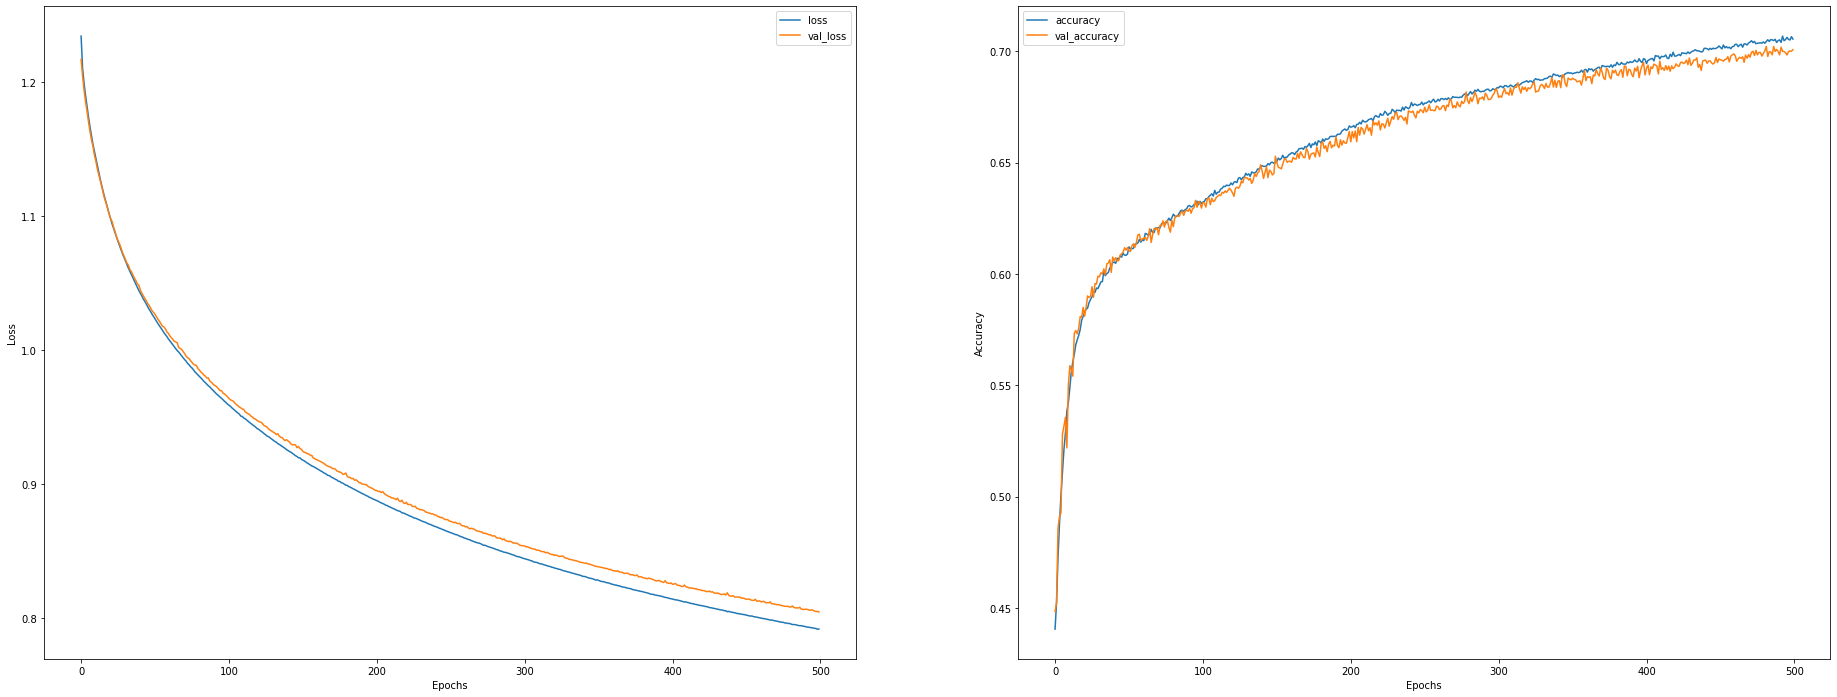

In [27]:
#Plotiting training results
plt.figure(figsize=(32,12))
plt.subplot(1,2,1)
plt.plot(range(len(history.history["loss"])), history.history['loss'], label="loss")
plt.plot(range(len(history.history["loss"])), history.history['val_loss'], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(len(history.history["loss"])), history.history["accuracy"], label="accuracy")
plt.plot(range(len(history.history["loss"])), history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [28]:
LinearModel.evaluate(test_norm, test_label)

31/31 [==============================] - 0s 2ms/step - loss: 0.9292 - accuracy: 0.5847


[0.9292380213737488, 0.5847107172012329]